# Voice processing

In [1]:
# Import libraries
import librosa
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
import os
from scipy.signal import spectrogram
import glob

In [2]:
# Load audio file
path = os.path.join(os.getcwd(), "data")
wav_files = glob.glob(os.path.join(path, "*.wav"))
path = os.path.join(os.getcwd(), "data")
file_path = wav_files[0]
y, sr = librosa.load(file_path, sr=None)
print(f"Audio duration: {librosa.get_duration(y=y, sr=sr):.2f} seconds")
print(f"Sample rate: {sr} Hz")

Audio duration: 60.03 seconds
Sample rate: 16000 Hz


In [3]:
# Normalize amplitude
y = y / np.max(np.abs(y))

In [4]:
# Detect non-silent segments
non_silent_intervals = librosa.effects.split(y, top_db=20)
y_trimmed = np.concatenate([y[start:end] for start, end in non_silent_intervals])

## Spectral analysis

### STFT Spectrogram

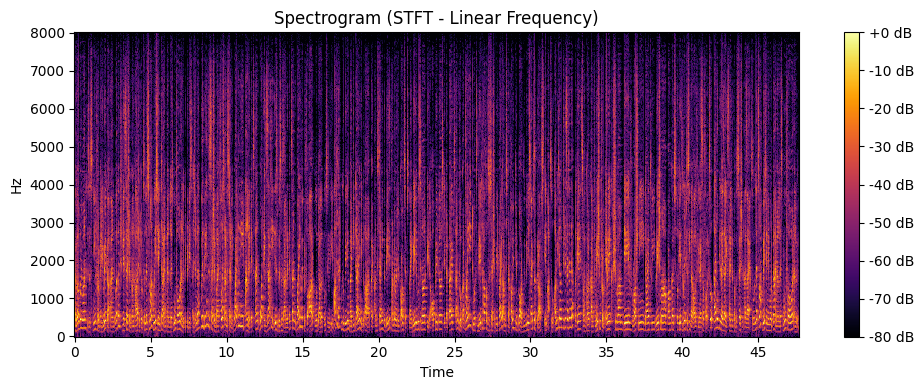

In [5]:
# -----------------------------
# STFT Spectrogram
# -----------------------------
D = np.abs(librosa.stft(y_trimmed, n_fft=1024, hop_length=512))  # magnitude
DB = librosa.amplitude_to_db(D, ref=np.max)

plt.figure(figsize=(10, 4))
librosa.display.specshow(DB, sr=sr, hop_length=512, x_axis='time', y_axis='linear', cmap='inferno')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram (STFT - Linear Frequency)')
plt.tight_layout()
plt.show()

### Mel-Spectrogram

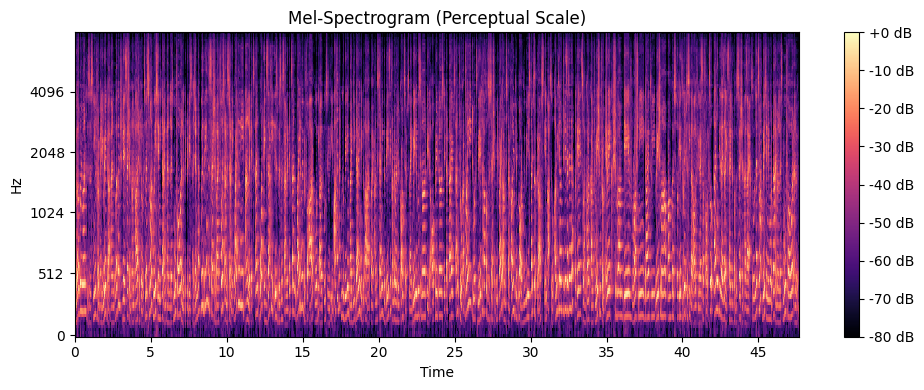

In [6]:
# -----------------------------
# Mel-Spectrogram
# -----------------------------
mel_spec = librosa.feature.melspectrogram(y=y_trimmed, sr=sr, n_fft=1024, hop_length=512, n_mels=128)
mel_db = librosa.power_to_db(mel_spec, ref=np.max)

plt.figure(figsize=(10, 4))
librosa.display.specshow(mel_db, sr=sr, hop_length=512, x_axis='time', y_axis='mel', cmap='magma')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-Spectrogram (Perceptual Scale)')
plt.tight_layout()
plt.show()

### MFCCs (visual)

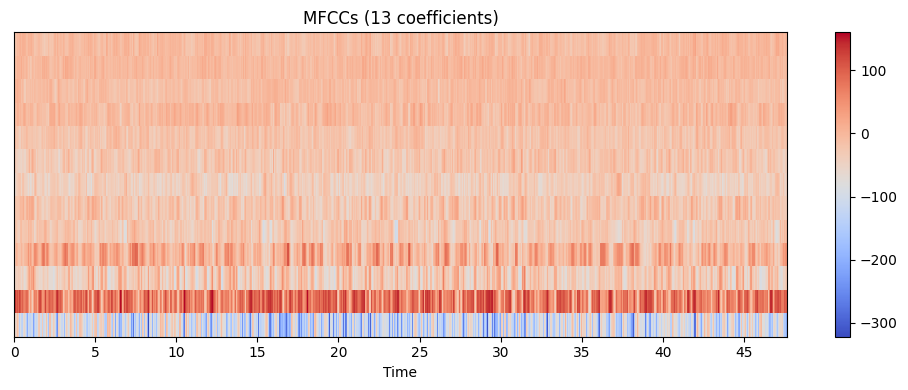

In [7]:
# -----------------------------
# MFCCs (Mel Frequency Cepstral Coefficients)
# -----------------------------
mfccs = librosa.feature.mfcc(y=y_trimmed, sr=sr, n_mfcc=13, hop_length=512)

plt.figure(figsize=(10, 4))
librosa.display.specshow(mfccs, sr=sr, hop_length=512, x_axis='time')
plt.colorbar()
plt.title('MFCCs (13 coefficients)')
plt.tight_layout()
plt.show()

## Prosodic analysis

### Pitch Analysis

In [8]:
# ---- PITCH ANALYSIS ----
# Pitch gives us information about intonation and vocal expressiveness.
# A flat pitch (low std or range) may indicate monotone speech.

pitches, magnitudes = librosa.piptrack(y=y_trimmed, sr=sr)
pitch_values = pitches[magnitudes > np.median(magnitudes)]  # filter out low-energy frames

pitch_mean = np.mean(pitch_values) if len(pitch_values) > 0 else 0
pitch_std = np.std(pitch_values) if len(pitch_values) > 0 else 0
pitch_range = np.max(pitch_values) - np.min(pitch_values) if len(pitch_values) > 0 else 0

print(f"Pitch mean: {pitch_mean:.2f} Hz")         # Average pitch (intonation center)
print(f"Pitch std: {pitch_std:.2f} Hz")           # Variation in pitch — higher std = more expressive
print(f"Pitch range: {pitch_range:.2f} Hz")       # Overall pitch span — tells us vocal dynamism

Pitch mean: 1410.50 Hz
Pitch std: 1013.66 Hz
Pitch range: 3843.52 Hz


### Energy (RMS) Analysis

In [10]:
# ---- ENERGY ANALYSIS ----
# Energy relates to perceived loudness and speech emphasis.
# Variation in energy (std) reflects dynamics and prosodic emphasis.

energy = librosa.feature.rms(y=y_trimmed)[0]

energy_mean = np.mean(energy)
energy_std = np.std(energy)

print(f"Energy mean: {energy_mean:.4f}")          # Average loudness
print(f"Energy std: {energy_std:.4f}")            # Variation in loudness — flat = dull, varied = dynamic

Energy mean: 0.1747
Energy std: 0.0827


### Pause / Silence Analysis

In [12]:
# ---- PAUSE / SILENCE ANALYSIS ----
# We detect pauses by identifying non-silent intervals.
# This tells us about speech rhythm, hesitation, and fluency.

non_silent_intervals = librosa.effects.split(y, top_db=20)  # segments considered "speech"

durations = [(end - start) / sr for start, end in non_silent_intervals]
total_speech_duration = sum(durations)                      # actual voiced segments
total_duration = librosa.get_duration(y=y, sr=sr)
silence_duration = total_duration - total_speech_duration
pause_count = len(non_silent_intervals) - 1                 # number of pauses = speech chunks - 1

print(f"Total audio duration: {total_duration:.2f} s")      # Full duration
print(f"Spoken duration: {total_speech_duration:.2f} s")    # Time actually speaking
print(f"Silence duration: {silence_duration:.2f} s")        # Total silence between phrases
print(f"Number of pauses: {pause_count}")                   # Count of pauses
print(f"% Silence: {(silence_duration / total_duration) * 100:.2f}%")  # Silence ratio

Total audio duration: 60.03 s
Spoken duration: 47.65 s
Silence duration: 12.38 s
Number of pauses: 38
% Silence: 20.63%


### Visual comparison

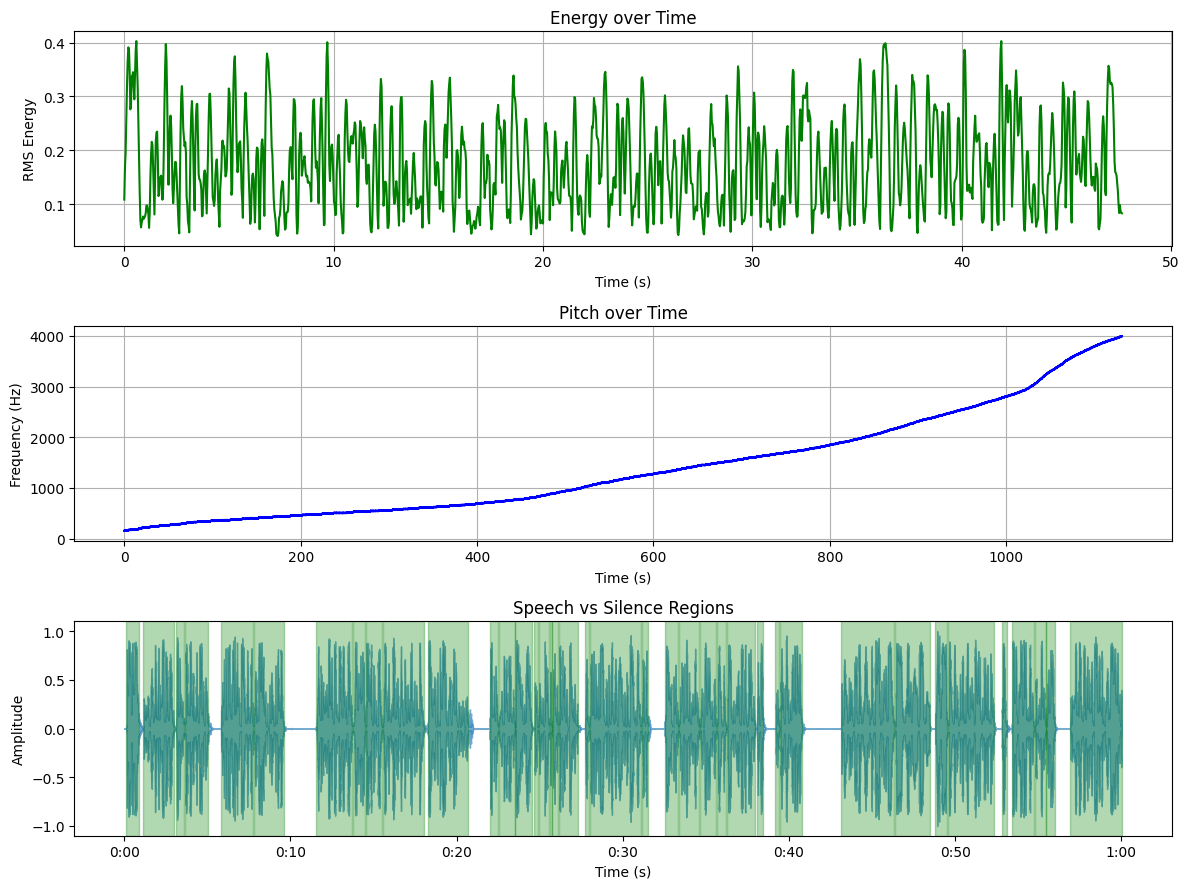

In [ ]:
# Plot summary
plt.figure(figsize=(12, 9))

# Energy over time
plt.subplot(3, 1, 1)
frames = range(len(energy))
t = librosa.frames_to_time(frames, sr=sr)
plt.plot(t, energy, label="Energy", color="green")
plt.title("Energy over Time")
plt.ylabel("RMS Energy")
plt.xlabel("Time (s)")
plt.grid(True)

# Pitch over time
plt.subplot(3, 1, 2)
times = librosa.frames_to_time(range(len(pitch_values)), sr=sr)
plt.plot(times, pitch_values, label="Pitch", color="blue")
plt.title("Pitch over Time")
plt.ylabel("Frequency (Hz)")
plt.xlabel("Time (s)")
plt.grid(True)

# Pause/Silence
plt.subplot(3, 1, 3)
librosa.display.waveshow(y, sr=sr, alpha=0.6)
plt.title("Speech vs Silence Regions")
for interval in non_silent_intervals:
    start, end = interval / sr
    plt.axvspan(start, end, color='green', alpha=0.3)  # highlight speech
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")

# Plot all of them
plt.tight_layout()
plt.show()